<a href="https://colab.research.google.com/github/SYKIM5396/Airline_Satisfaction/blob/main/Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders
!pip install --upgrade xgboost
!pip install --upgrade lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 255.9 MB 49 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 23.7 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

%matplotlib inline
plt.rcParams["figure.dpi"] = 144

import numpy as np
from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder, OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")


데이터 불러오기

In [3]:
#데이터셋 불러오기
train = pd.read_csv('https://raw.githubusercontent.com/SYKIM5396/Airline_Satisfaction/main/train_processed.csv')
test = pd.read_csv('https://raw.githubusercontent.com/SYKIM5396/Airline_Satisfaction/main/test_processed.csv')

# 3.다양한 모델 설계 및 비교

데이터 분리

In [4]:
target = 'satisfaction'

train, val = train_test_split(
    train, train_size=0.80, test_size=0.20, stratify=train[target], random_state=53)

X_train, y_train = train.drop(columns=target), train[target]
X_val, y_val = val.drop(columns=target), val[target]
X_test, y_test = test.drop(columns=target), test[target]

## 기준모델 선정

기준모델은 타겟의 최빈 클래스로 설정합니다.

In [5]:
def eval_models(y_pred, y_pred_proba, y_real=y_val) :
    accuracy = accuracy_score(y_real, y_pred)
    precision = precision_score(y_real, y_pred)
    recall = recall_score(y_real, y_pred)
    f1 = f1_score(y_real, y_pred)
    auc = roc_auc_score(y_val, y_pred_proba)

    print(f'accuracy : {accuracy.round(2)}')
    print(f'precision : {precision.round(2)}')
    print(f'recall : {recall.round(2)}')
    print(f'f1 : {f1.round(2)}')
    print(f"auc score : {auc.round(3)}")

    return accuracy, precision, recall, f1, auc

In [6]:
base = y_train.mode()[0]
baseline = len(y_val) * [base]

eval_models(baseline,baseline);

accuracy : 0.57
precision : 0.0
recall : 0.0
f1 : 0.0
auc score : 0.5


## Logistic Regression

In [7]:
# 수치형 특성만 스케일링
sclaer = StandardScaler()
num_cols = ['Age','Flight_Distance','Average_delay','Overall_Rating']

X_train_scaled, X_val_scaled, X_test_scaled = X_train.copy(), X_val.copy(), X_test.copy()

scaler = StandardScaler()
X_train_scaled[num_cols] = scaler.fit_transform(X_train_scaled[num_cols])
X_val_scaled[num_cols] = scaler.transform(X_val_scaled[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test_scaled[num_cols])

In [8]:
nominal_cols = ['Gender', 'Customer_Type', 'Type_of_Travel', 'Class']

Cs = np.power(10.0, np.arange(-10, 10))

pire_LR_CV = make_pipeline(
        OneHotEncoder(use_cat_names=True, cols = nominal_cols),
        LogisticRegressionCV(Cs=Cs, cv=5, max_iter=1000,scoring="f1", random_state=53)
            )
pire_LR_CV.fit(X_train_scaled, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Gender', 'Customer_Type',
                                     'Type_of_Travel', 'Class'],
                               use_cat_names=True)),
                ('logisticregressioncv',
                 LogisticRegressionCV(Cs=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09]),
                                      cv=5, max_iter=1000, random_state=53,
                                      scoring='f1'))])

In [10]:
#최적의 C는
pire_LR_CV.named_steps['logisticregressioncv'].C_

array([10000.])

In [11]:
y_pred_LR = pire_LR_CV.predict(X_val_scaled)
y_pred_proba_LR = pire_LR_CV.predict_proba(X_val_scaled)[:,1]

print("훈련 f1 ", pire_LR_CV.score(X_train_scaled, y_train))
eval_models(y_pred_LR,y_pred_proba_LR)

훈련 f1  0.8537980238385098
accuracy : 0.87
precision : 0.87
recall : 0.83
f1 : 0.85
auc score : 0.926


(0.8733458447620422,
 0.8727336530588373,
 0.8285397001665741,
 0.8500626637803349,
 0.9260867019077567)

In [12]:
#로지스틱 회귀모델의 회귀계수 확인
pd.Series(pire_LR_CV.named_steps['logisticregressioncv'].coef_[0], pire_LR_CV.named_steps['logisticregressioncv'].feature_names_in_).sort_values(ascending=False)

Type_of_Travel_Business travel       1.350303
Customer_Type_Loyal Customer         0.997185
Online_boarding                      0.586215
Class_Business                       0.514911
Inflight_wifi_service                0.359833
Checkin_service                      0.301174
On-board_service                     0.276352
Overall_Rating                       0.262757
Leg_room_service                     0.226982
Cleanliness                          0.187123
Baggage_handling                     0.117800
Inflight_service                     0.078277
Inflight_entertainment               0.043114
Seat_comfort                         0.038082
Gender_Male                          0.010891
Gate_location                        0.010636
Flight_Distance                     -0.002212
Gender_Female                       -0.023958
Food_and_drink                      -0.053763
Age                                 -0.115546
Departure/Arrival_time_convenient   -0.156370
Ease_of_Online_booking            

## RandomForest

In [13]:
mapping = [{'col': 'Gender', 'mapping': {'Female' : 1,  'Male' : 2,  None :-2}},
 {'col': 'Customer_Type', 'mapping': {'disloyal Customer' :1, 'Loyal Customer' : 2,  None :-2}},
 {'col': 'Type_of_Travel', 'mapping': {'Personal Travel' :   1 ,  'Business travel' :  2, None :-2}},
 {'col': 'Class', 'mapping': {'Eco':1, 'Eco Plus' : 2 ,'Business':3,  None :-2}}
]

In [14]:
params = {'randomforestclassifier__max_depth': np.arange(3, 15, 2),
               'randomforestclassifier__min_samples_split': [2, 4, 8, 16],
               'randomforestclassifier__min_samples_leaf': [1, 2, 4]
               }

In [15]:
pipe_rf = make_pipeline(
        OrdinalEncoder(mapping=mapping),
        RandomForestClassifier(random_state=53,
                               oob_score=False, 
                               n_estimators=100,
                               n_jobs=-1)
        )

rf_random = RandomizedSearchCV(pipe_rf, param_distributions = params, scoring="f1", n_iter = 10, cv = 5, verbose=3, random_state=53)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END randomforestclassifier__max_depth=9, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=16;, score=0.931 total time=   5.2s
[CV 2/5] END randomforestclassifier__max_depth=9, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=16;, score=0.932 total time=   3.9s
[CV 3/5] END randomforestclassifier__max_depth=9, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=16;, score=0.927 total time=   4.3s
[CV 4/5] END randomforestclassifier__max_depth=9, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=16;, score=0.928 total time=   3.5s
[CV 5/5] END randomforestclassifier__max_depth=9, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=16;, score=0.932 total time=   4.2s
[CV 1/5] END randomforestclassifier__max_depth=3, randomforestclassifier__min_s

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(mapping=[{'col': 'Gender',
                                                                       'mapping': {None: -2,
                                                                                   'Female': 1,
                                                                                   'Male': 2}},
                                                                      {'col': 'Customer_Type',
                                                                       'mapping': {None: -2,
                                                                                   'Loyal Customer': 2,
                                                                                   'disloyal Customer': 1}},
                                                                      {'col': 'Type_of_Travel',
                                         

In [16]:
rf_random.best_params_

{'randomforestclassifier__min_samples_split': 8,
 'randomforestclassifier__min_samples_leaf': 4,
 'randomforestclassifier__max_depth': 13}

In [17]:
y_pred_rf = rf_random.best_estimator_.predict(X_val)
y_pred_proba_rf = rf_random.best_estimator_.predict_proba(X_val)[:,1]

print("훈련 f1 ", rf_random.best_estimator_.score(X_train, y_train))
eval_models(y_pred_rf,y_pred_proba_rf)

훈련 f1  0.9620321691950483
accuracy : 0.95
precision : 0.96
recall : 0.93
f1 : 0.95
auc score : 0.992


(0.9539964390549059,
 0.9603111060276793,
 0.9323709050527484,
 0.9461347757493801,
 0.9919328105762499)

## LGBMClassifier

In [18]:
params = {'lgbmclassifier__max_depth': np.arange(-1, 15, 4),
            'lgbmclassifier__min_child_weight': [2, 4, 8, 16],
            'lgbmclassifier__n_estimators' : np.arange(100, 1000, 100)
               }

In [19]:
pipe_lgbm = make_pipeline(
        OrdinalEncoder(mapping=mapping),
        LGBMClassifier(random_state=53,
                       learning_rate=0.1,                              
                               n_jobs=-1)
        )

lgbm_random = RandomizedSearchCV(pipe_lgbm, param_distributions = params, scoring="f1", n_iter = 10, cv = 5, verbose=3, random_state=53)
lgbm_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_weight=2, lgbmclassifier__n_estimators=900;, score=0.957 total time=   8.6s
[CV 2/5] END lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_weight=2, lgbmclassifier__n_estimators=900;, score=0.957 total time=   6.5s
[CV 3/5] END lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_weight=2, lgbmclassifier__n_estimators=900;, score=0.955 total time=   5.2s
[CV 4/5] END lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_weight=2, lgbmclassifier__n_estimators=900;, score=0.956 total time=   5.0s
[CV 5/5] END lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_weight=2, lgbmclassifier__n_estimators=900;, score=0.954 total time=   5.3s
[CV 1/5] END lgbmclassifier__max_depth=11, lgbmclassifier__min_child_weight=8, lgbmclassifier__n_estimators=600;, score=0.958 total time=   4.0s
[CV 2/5] END lgbmclassifier__max_depth=11, lgbmclassifier__min_child_

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(mapping=[{'col': 'Gender',
                                                                       'mapping': {None: -2,
                                                                                   'Female': 1,
                                                                                   'Male': 2}},
                                                                      {'col': 'Customer_Type',
                                                                       'mapping': {None: -2,
                                                                                   'Loyal Customer': 2,
                                                                                   'disloyal Customer': 1}},
                                                                      {'col': 'Type_of_Travel',
                                         

In [20]:
lgbm_random.best_params_

{'lgbmclassifier__n_estimators': 200,
 'lgbmclassifier__min_child_weight': 4,
 'lgbmclassifier__max_depth': 11}

In [21]:
y_pred_lgbm = lgbm_random.best_estimator_.predict(X_val)
y_pred_proba_lgbm = lgbm_random.best_estimator_.predict_proba(X_val)[:,1]

print("훈련 f1 ", lgbm_random.best_estimator_.score(X_train, y_train))
eval_models(y_pred_lgbm,y_pred_proba_lgbm)

훈련 f1  0.9715000661670056
accuracy : 0.96
precision : 0.98
recall : 0.94
f1 : 0.96
auc score : 0.996


(0.9645349116981858,
 0.9762672811059908,
 0.9410327595780122,
 0.9583262651964942,
 0.9955792128618159)

## XGBClassifier

In [22]:
params={'xgbclassifier__max_depth': np.arange(3, 15, 2),
        "xgbclassifier__min_child_weight" : [4,8,16],
        "xgbclassifier__n_estimators" : np.arange(100, 800, 100)
    }

In [24]:
pipe_xgb = make_pipeline(
        OrdinalEncoder(mapping=mapping),
        XGBClassifier(
            objective="binary:logistic",
            eval_metric="error",
            random_state=53,
            learning_rate=0.1,
            n_jobs=-1,
            ))
        
xgb_random = RandomizedSearchCV(pipe_xgb, param_distributions = params, scoring="f1", n_iter = 10, cv = 5, verbose=3, random_state=53)
xgb_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END xgbclassifier__max_depth=3, xgbclassifier__min_child_weight=4, xgbclassifier__n_estimators=100;, score=0.929 total time=   2.9s
[CV 2/5] END xgbclassifier__max_depth=3, xgbclassifier__min_child_weight=4, xgbclassifier__n_estimators=100;, score=0.932 total time=   2.9s
[CV 3/5] END xgbclassifier__max_depth=3, xgbclassifier__min_child_weight=4, xgbclassifier__n_estimators=100;, score=0.927 total time=   3.0s
[CV 4/5] END xgbclassifier__max_depth=3, xgbclassifier__min_child_weight=4, xgbclassifier__n_estimators=100;, score=0.931 total time=   3.0s
[CV 5/5] END xgbclassifier__max_depth=3, xgbclassifier__min_child_weight=4, xgbclassifier__n_estimators=100;, score=0.927 total time=   3.0s
[CV 1/5] END xgbclassifier__max_depth=3, xgbclassifier__min_child_weight=16, xgbclassifier__n_estimators=600;, score=0.953 total time=  16.2s
[CV 2/5] END xgbclassifier__max_depth=3, xgbclassifier__min_child_weight=16, xgbclassifier__

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(mapping=[{'col': 'Gender',
                                                                       'mapping': {None: -2,
                                                                                   'Female': 1,
                                                                                   'Male': 2}},
                                                                      {'col': 'Customer_Type',
                                                                       'mapping': {None: -2,
                                                                                   'Loyal Customer': 2,
                                                                                   'disloyal Customer': 1}},
                                                                      {'col': 'Type_of_Travel',
                                         

In [25]:
xgb_random.best_params_

{'xgbclassifier__n_estimators': 100,
 'xgbclassifier__min_child_weight': 8,
 'xgbclassifier__max_depth': 11}

In [26]:
y_pred_xgb = xgb_random.best_estimator_.predict(X_val)
y_pred_proba_xgb = xgb_random.best_estimator_.predict_proba(X_val)[:,1]

print("훈련 auc ", xgb_random.best_estimator_.score(X_train, y_train))
eval_models(y_pred_xgb,y_pred_proba_xgb)

훈련 auc  0.9763603334817078
accuracy : 0.96
precision : 0.98
recall : 0.94
f1 : 0.96
auc score : 0.996


(0.9647273952167845,
 0.9756209751609936,
 0.9421432537479179,
 0.9585899101745664,
 0.9955309022161601)

## 모델 비교

In [27]:
comparison_metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'f1', 'auc'], columns=['Base','Logistic', 'Randomforest', 'LGBM', 'XGBoost'])
comparison_metrics['Base'] = eval_models(baseline,baseline)
comparison_metrics['Logistic'] =eval_models(y_pred_LR,y_pred_proba_LR)
comparison_metrics['Randomforest'] =eval_models(y_pred_rf,y_pred_proba_rf)
comparison_metrics['LGBM'] =eval_models(y_pred_lgbm,y_pred_proba_lgbm)
comparison_metrics['XGBoost'] =eval_models(y_pred_xgb,y_pred_proba_xgb)
comparison_metrics.round(3)

accuracy : 0.57
precision : 0.0
recall : 0.0
f1 : 0.0
auc score : 0.5
accuracy : 0.87
precision : 0.87
recall : 0.83
f1 : 0.85
auc score : 0.926
accuracy : 0.95
precision : 0.96
recall : 0.93
f1 : 0.95
auc score : 0.992
accuracy : 0.96
precision : 0.98
recall : 0.94
f1 : 0.96
auc score : 0.996
accuracy : 0.96
precision : 0.98
recall : 0.94
f1 : 0.96
auc score : 0.996


,Base,Logistic,Randomforest,LGBM,XGBoost
accuracy,0.567,0.873,0.954,0.965,0.965
precision,0.000,0.873,0.960,0.976,0.976
recall,0.000,0.829,0.932,0.941,0.942
f1,0.000,0.850,0.946,0.958,0.959
auc,0.500,0.926,0.992,0.996,0.996


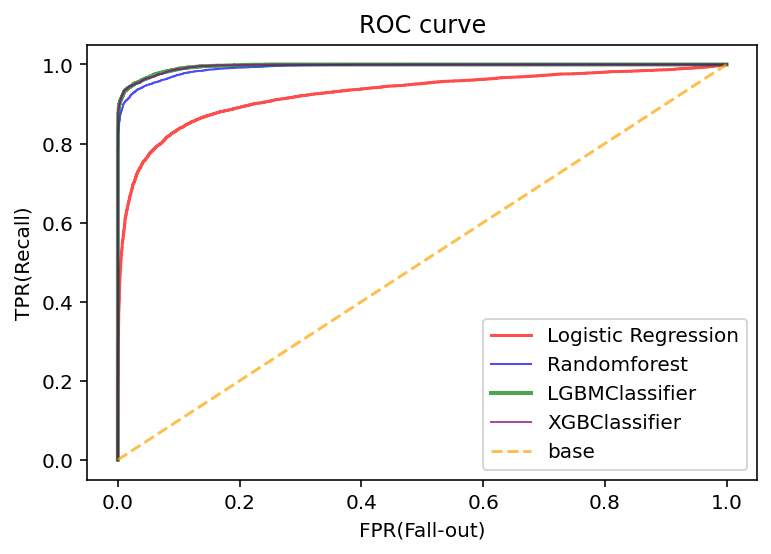

In [28]:

fpr, tpr, thresholds = roc_curve(y_val,y_pred_proba_LR)
plt.plot(fpr, tpr, label='Logistic Regression', color = 'red',alpha=0.7)

fpr, tpr, thresholds = roc_curve(y_val,y_pred_proba_rf)
plt.plot(fpr, tpr, label='Randomforest', color = 'blue',lw=1,alpha=0.7)

fpr, tpr, thresholds = roc_curve(y_val,y_pred_proba_lgbm)
plt.plot(fpr, tpr, label='LGBMClassifier', color = 'green',lw=2,alpha=0.7)

fpr, tpr, thresholds = roc_curve(y_val,y_pred_proba_xgb)
plt.plot(fpr, tpr, label='XGBClassifier', color = 'purple',lw=1 ,alpha=0.7)

fpr, tpr, thresholds = roc_curve(y_val,baseline)
plt.plot(fpr, tpr, label='base',linestyle='--', color = 'orange',alpha=0.7)

plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')
plt.legend();

성능은 XGB와 거의 비슷하지만 모델 속도에 뛰어난 모습을 보이는 LGBMClassifier를 최종모델로 선정하겠습니다.  
데이터 샘플이 10만개 이상이라 모델의 속도도 중요하다고 판단했습니다.